X_train_seq shape: torch.Size([7413, 72, 3])
y_train_seq shape: torch.Size([7413, 12])
Input size: 3
Output size: 12
Training RNN model:
Epoch [10/50], Loss: 0.4927
Epoch [20/50], Loss: 0.4673
Epoch [30/50], Loss: 0.4631
Epoch [40/50], Loss: 0.4703
Epoch [50/50], Loss: 0.4406

Training LSTM model:
Epoch [10/50], Loss: 0.4463
Epoch [20/50], Loss: 0.4257
Epoch [30/50], Loss: 0.4151
Epoch [40/50], Loss: 0.4164
Epoch [50/50], Loss: 0.3961


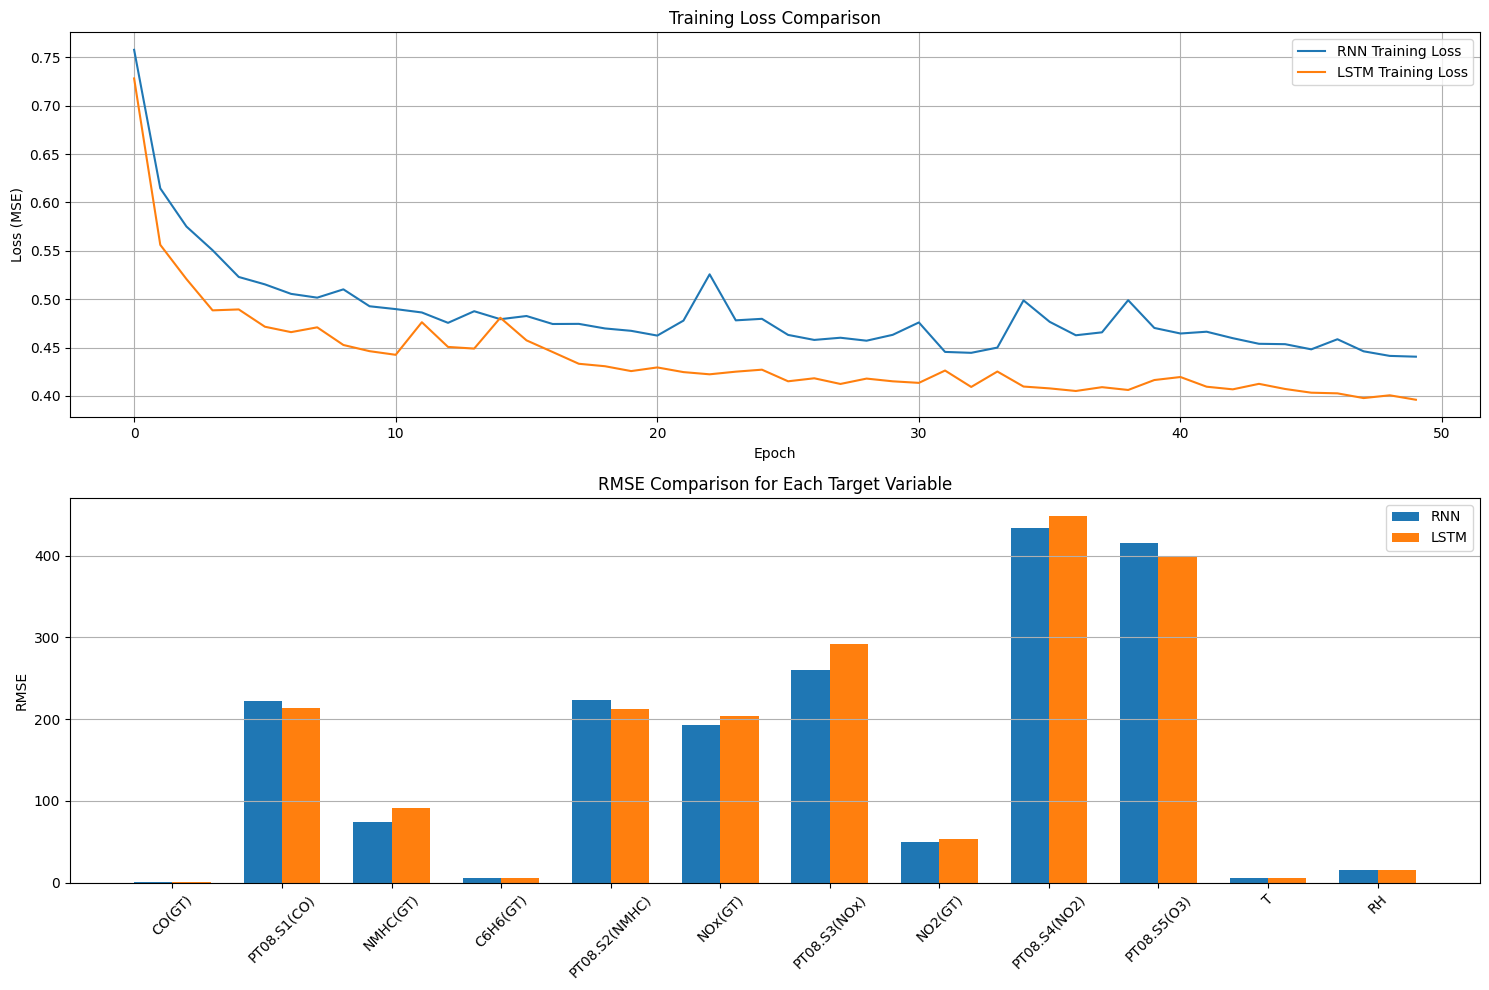


RNN RMSE Results:
CO(GT): 1.1982
PT08.S1(CO): 221.8061
NMHC(GT): 74.3965
C6H6(GT): 5.8529
PT08.S2(NMHC): 223.7719
NOx(GT): 193.4703
PT08.S3(NOx): 259.6598
NO2(GT): 49.4377
PT08.S4(NO2): 433.9361
PT08.S5(O3): 415.3338
T: 5.7218
RH: 15.1798

LSTM RMSE Results:
CO(GT): 1.1261
PT08.S1(CO): 213.3552
NMHC(GT): 91.2119
C6H6(GT): 5.5477
PT08.S2(NMHC): 212.7102
NOx(GT): 203.3310
PT08.S3(NOx): 291.6351
NO2(GT): 54.0903
PT08.S4(NO2): 448.1283
PT08.S5(O3): 398.2734
T: 6.1334
RH: 15.2432


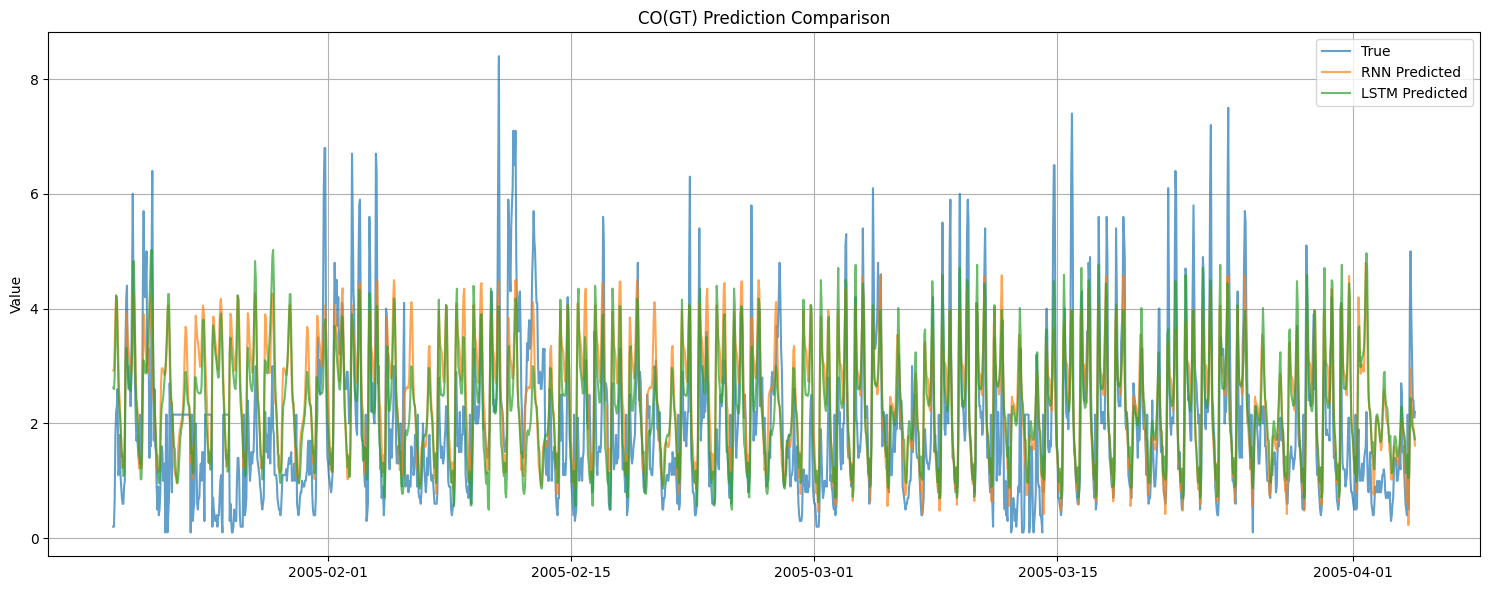

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 数据预处理
def preprocess_data(df):
    df['datetime'] = pd.to_datetime(
        df['Date'].astype(str) + ' ' + df['Time'].astype(str),
        format='%d/%m/%Y %H.%M.%S'
    )
    df = df.sort_values('datetime')
    
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].replace(-200, np.nan)
    
    cols_to_exclude = ['hour', 'day_of_week', 'month']
    valid_numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]
    col_means = df[valid_numeric_cols].mean()
    df[valid_numeric_cols] = df[valid_numeric_cols].fillna(col_means)
    
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    
    target_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
                      'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
                      'PT08.S5(O3)', 'T', 'RH',]
    
    final_numeric_cols = df.select_dtypes(include=np.number).columns
    X = df[final_numeric_cols].drop(target_columns, axis=1)
    y = df[target_columns]
    
    return X, y, df

# 加载数据集
df = pd.read_csv('C:\\Users\\endorphin\\Desktop\\神经网络\\作业3\\AirQualityUCI.csv')  
X, y, df = preprocess_data(df)

# 按时间顺序分割数据集
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train_orig, y_test_orig = y.iloc[:train_size], y.iloc[train_size:]

# 标准化
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_orig)
y_test = scaler_y.transform(y_test_orig)

# 转换为张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  

# 设置序列长度
seq_length = 72  # 使用前24小时数据预测下一小时

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return torch.stack(X_seq), torch.stack(y_seq)

# 创建序列数据
X_train_seq, y_train_seq = create_sequences(X_train_tensor, y_train_tensor, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_tensor, y_test_tensor, seq_length)  

# 验证数据维度
print(f"X_train_seq shape: {X_train_seq.shape}")  # 应是 [样本数, 序列长度, 特征数]
print(f"y_train_seq shape: {y_train_seq.shape}")  # 应是 [样本数, 目标变量数]

# 创建数据加载器
train_loader = DataLoader(TensorDataset(X_train_seq, y_train_seq), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_seq, y_test_seq), batch_size=32)

# RNN模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN层
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播RNN
        out, _ = self.rnn(x, h0)
        
        # 只取序列的最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        return out

# LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # 只取序列的最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        return out

# 设置模型参数
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
output_size = y_train.shape[1]  

print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

# 训练函数
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    
    return train_losses

# 评估函数
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            predictions.append(outputs.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    predictions = np.vstack(predictions)
    
    return avg_loss, predictions

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 训练RNN模型
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
rnn_criterion = nn.MSELoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

print("Training RNN model:")
rnn_train_losses = train_model(rnn_model, train_loader, rnn_criterion, rnn_optimizer, epochs=50, device=device)
rnn_test_loss, rnn_predictions = evaluate_model(rnn_model, test_loader, rnn_criterion, device=device)

# 训练LSTM模型
lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
lstm_criterion = nn.MSELoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

print("\nTraining LSTM model:")
lstm_train_losses = train_model(lstm_model, train_loader, lstm_criterion, lstm_optimizer, epochs=50, device=device)
lstm_test_loss, lstm_predictions = evaluate_model(lstm_model, test_loader, lstm_criterion, device=device)

# 反标准化预测结果
rnn_y_pred = scaler_y.inverse_transform(rnn_predictions)
lstm_y_pred = scaler_y.inverse_transform(lstm_predictions)

# 保留与预测对应的真实值
y_test_orig_cropped = y_test_orig.iloc[seq_length:].reset_index(drop=True)

# 计算RMSE
def calculate_rmse(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2, axis=0))

rnn_rmse = calculate_rmse(y_test_orig_cropped.values, rnn_y_pred)
lstm_rmse = calculate_rmse(y_test_orig_cropped.values, lstm_y_pred)

# 对比结果可视化
plt.figure(figsize=(15, 10))

# 训练损失对比
plt.subplot(2, 1, 1)
plt.plot(rnn_train_losses, label='RNN Training Loss')
plt.plot(lstm_train_losses, label='LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# RMSE对比
plt.subplot(2, 1, 2)
x = np.arange(len(y.columns))
width = 0.35
plt.bar(x - width/2, rnn_rmse, width, label='RNN')
plt.bar(x + width/2, lstm_rmse, width, label='LSTM')
plt.xticks(x, y.columns, rotation=45)
plt.ylabel('RMSE')
plt.title('RMSE Comparison for Each Target Variable')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# 打印RMSE结果
print("\nRNN RMSE Results:")
for i, col in enumerate(y.columns):
    print(f"{col}: {rnn_rmse[i]:.4f}")

print("\nLSTM RMSE Results:")
for i, col in enumerate(y.columns):
    print(f"{col}: {lstm_rmse[i]:.4f}")

# 为一个变量绘制预测对比图
feature_to_plot = 'CO(GT)'
feature_idx = y.columns.get_loc(feature_to_plot)

time_axis = df['datetime'].iloc[train_size+seq_length:].reset_index(drop=True)

plt.figure(figsize=(15, 6))
plt.plot(time_axis, y_test_orig_cropped[feature_to_plot], label='True', alpha=0.7)
plt.plot(time_axis, rnn_y_pred[:, feature_idx], label='RNN Predicted', alpha=0.7)
plt.plot(time_axis, lstm_y_pred[:, feature_idx], label='LSTM Predicted', alpha=0.7)
plt.title(f'{feature_to_plot} Prediction Comparison')
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{feature_to_plot}_prediction_comparison.png')
plt.show()